In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BAT
using DSP

In [2]:
include("../model-35/likelihood.jl")
include("../model-35/utill_model.jl")
include("../utill.jl")

plot_projections (generic function with 1 method)

In [3]:
function hist_2d(smpls, dim_1, dim_2; nbins=40, axmin = true, axmax=true)
    smpl_tmp, smpl_w = flatview(unshaped.(smpls.v)), smpls.weight
    if axmin == true
        hist_tmp = fit(Histogram, (smpl_tmp[dim_1,:],smpl_tmp[dim_2,:]), FrequencyWeights(smpl_w), nbins=nbins)
    else
       hist_tmp = fit(Histogram, (smpl_tmp[dim_1,:],smpl_tmp[dim_2,:]), FrequencyWeights(smpl_w), (range(axmin[1], stop=axmax[1], length=nbins), range(axmin[2], stop=axmax[2], length=nbins))) 
    end
    hist_tmp = normalize(hist_tmp, mode=:pdf) 
    return hist_tmp
end

hist_2d (generic function with 1 method)

In [4]:
β1 = 0.015
β2 = 0.0077 # (0.8/30/sqrt(12))
β3 = 0.0058 # (0.8/40/sqrt(12))

# flat prior for the pixel size
prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.03, 0.20), truncated(Normal(0.2, 0.04), 0.03, 0.20)],
        ang_spr = [truncated(Normal(4.0, 2.0), 2.0, 7.0), truncated(Normal(4.0, 2.0), 2.0, 7.0)],
        waist = [Normal(2.9, 0.03)],
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [1.0, 1.0, 1.0], 
        resy = [1.0, 1.0, 1.0], 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf),
        psx = [27.1, 21.6, 114.0], # 31, 32, 33
        psy = [30.5, 23.4, 125.0], # 34, 35, 36
        cam4_psx = 121.8, # 37
        cam4_psy = 120.0, # 38
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.478, 15.026, 23.1150],
    );

labels = [L"\sigma_x", L"\sigma_y", L"\sigma_x", L"\sigma_y", L"\sigma'_x", L"\sigma'_y", L"\sigma'_x", L"\sigma'_y", L"\alpha", L"s", L"s",
    L"\mu_x", L"\mu_x", L"\mu_x", L"\mu_x", L"\mu_y", L"\mu_y", L"\mu_y", L"\mu_y", 
    "ped", "lf", "a", 
    "res x", "res x", "res x", "res y", "res y", "res y", "res x", "res y", 
    "ps x", "ps x", "ps x", "ps y", "ps y", "ps y", "ps x", "ps y", 
    "la", "la", "la"
    ];

In [5]:
FPATH = "../../data/sampling_results/Benchmark-10/"

"../../data/sampling_results/Benchmark-10/"

In [6]:
readdir(FPATH)

34-element Array{String,1}:
 "hc-124.hdf5"
 "hc-129.hdf5"
 "hc-158.hdf5"
 "hc-174.hdf5"
 "hc-181.hdf5"
 "hc-202.hdf5"
 "hc-224.hdf5"
 "hc-264.hdf5"
 "hc-268.hdf5"
 "hc-295.hdf5"
 "hc-3.hdf5"
 "hc-332.hdf5"
 "hc-367.hdf5"
 ⋮
 "lc-115.hdf5"
 "lc-131.hdf5"
 "lc-152.hdf5"
 "lc-218.hdf5"
 "lc-266.hdf5"
 "lc-281.hdf5"
 "lc-286.hdf5"
 "lc-323.hdf5"
 "lc-44.hdf5"
 "lc-57.hdf5"
 "lc-66.hdf5"
 "lc-89.hdf5"

In [7]:
filename = readdir(FPATH)[18]
smpl_tmp = bat_read(FPATH*filename)
samples = varshape(prior).(smpl_tmp);

In [8]:
filename

# Example HC "hc-2.hdf5"
# Example LC "lc-169.hdf5"

"hc-432.hdf5"

In [9]:
smpl_vect = mode(samples)[1]

(tr_size = [0.10444457902091418, 0.13307786755201664], ang_spr = [4.828320914336327, 4.635251719885723], waist = [3.3506287723345793], algmx = [34.863940330291335, 36.00042483627535, 21.365259004097517, 35.558296812400584], algmy = [34.24899603714203, 34.53900835780472, 20.56506812280467, 35.33340178691221], cam4_ped = 32.30778081445666, cam4_light_fluct = 1.9954030152272586, cam4_light_amp = 8.471319861859568, resx = [1.0, 1.0, 1.0], resy = [1.0, 1.0, 1.0], cam4_resx = 5.425536496310781, cam4_resy = 4.9317292122594, psx = [27.1, 21.6, 114.0], psy = [30.5, 23.4, 125.0], cam4_psx = 121.8, cam4_psy = 120.0, light_amp = [8.27276588863944, 11.122803526405296, 2.604048419354098], s_cam = [0.0, 1.478, 15.026, 23.115])

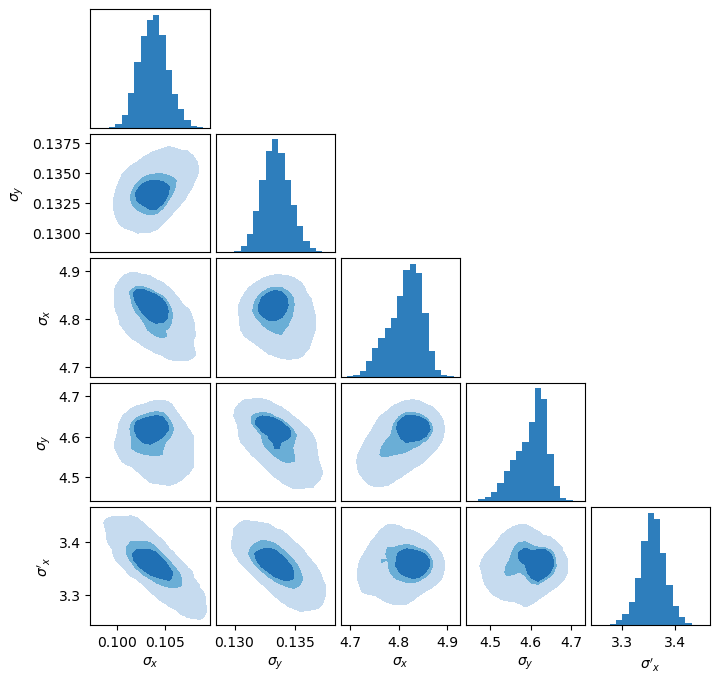

In [14]:
dims = [1,2,3,4,5]
names = labels[dims]
levels = [0.0001, 0.65, 0.9, 0.95,  1,]
# levels = [0.001, 0.65, 0.95, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

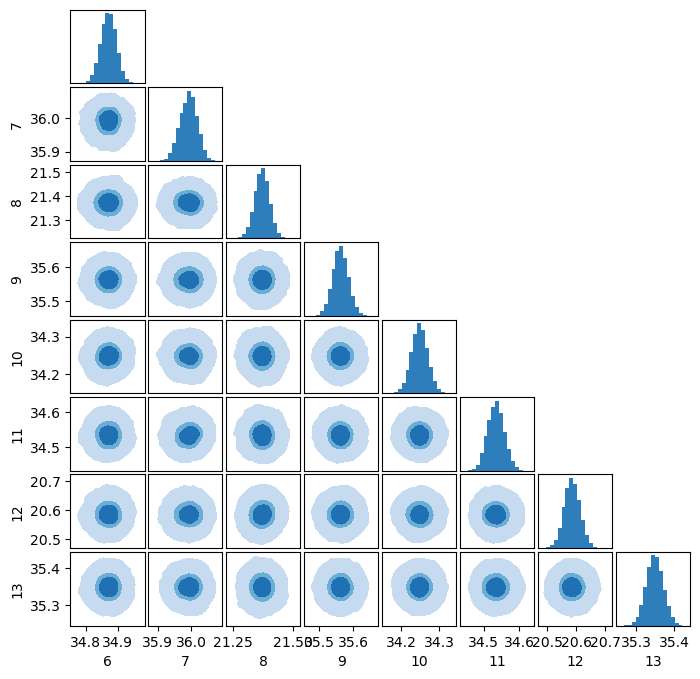

In [15]:
dims = 6:13
names = dims
levels = [0.01, 0.55, 0.9, 0.95,  1,]
# levels = [0.01, 0.65, 0.95, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

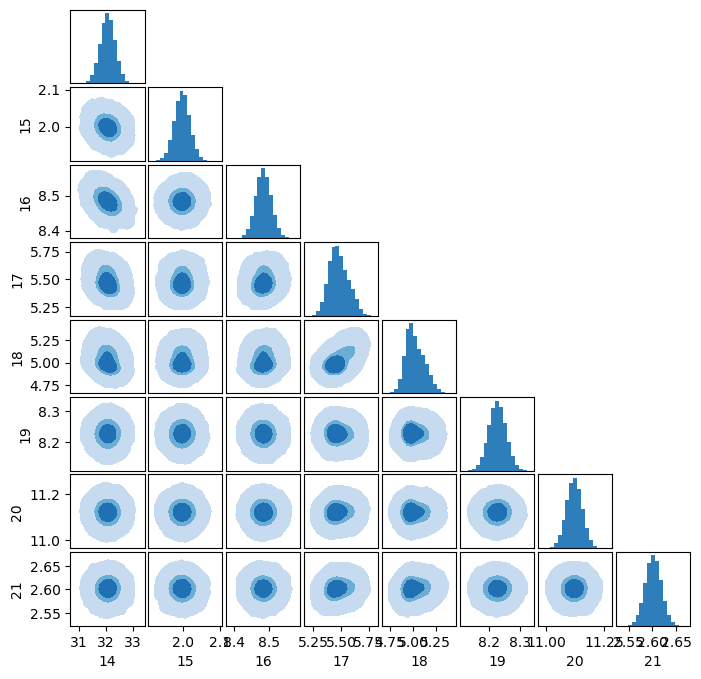

In [16]:
dims = 14:21
names = dims
levels = [0.01, 0.55, 0.9, 0.95,  1,]
# levels = [0.01, 0.65, 0.95, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

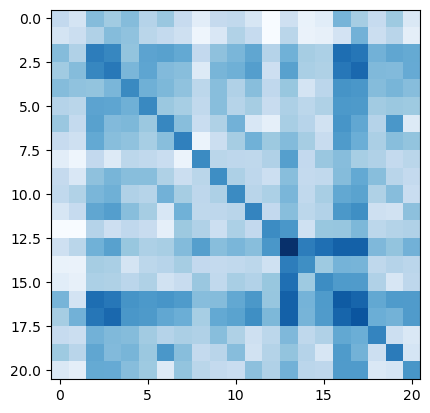

PyObject <matplotlib.image.AxesImage object at 0x7f6f19172f70>

In [17]:
plt.imshow(log.(abs.(cov(flatview(unshaped.(samples.v))'))), cmap="Blues")

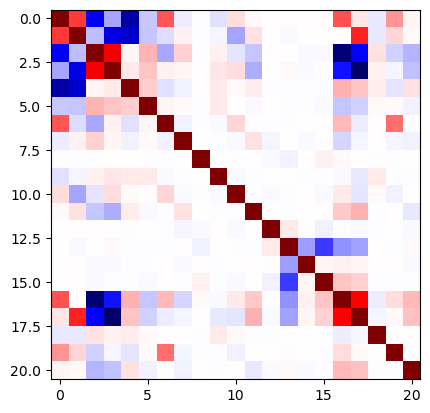

PyObject <matplotlib.image.AxesImage object at 0x7f6f1a3b38b0>

In [18]:
dt_reg = flatview(unshaped.(samples.v)) ./ std(flatview(unshaped.(samples.v)), dims=2)
dt_reg = dt_reg .- mean(dt_reg, dims=2)
dt_reg = cov(dt_reg')
max = maximum(abs.(dt_reg))

plt.imshow(dt_reg, cmap="seismic", vmin=-max, vmax=max)

In [19]:
if filename[1:2] == "hc"
    
    conv_mat = load("../../data/experiment/dataset_2/m2/conv-matrix-upd-2.jld2") 

    global conv_matrices = (
        cam_1 = conv_mat["cam_1"],
        cam_2 = conv_mat["cam_2"],
        cam_3 = conv_mat["cam_3"],
        cam_4 = conv_mat["cam_4"], 
    ) 

    images = load("../../data/experiment/dataset_2/m2/images-satur.jld2")
    event_number = parse(Int64, filename[4:end-5])

    global event = (
        cam_1 = images["cam_1"][event_number,:,:],
        cam_2 = images["cam_2"][event_number,:,:],
        cam_3 = images["cam_3"][event_number,:,:],
        cam_4 = images["cam_4"][event_number,:,:],
        population = images["charge"][event_number,:][1],
    );
    
    images = load("../../data/experiment/dataset_2/m2/images.jld2")

    global event_nt = (
        cam_1 = images["cam_1"][event_number,:,:],
        cam_2 = images["cam_2"][event_number,:,:],
        cam_3 = images["cam_3"][event_number,:,:],
        cam_4 = images["cam_4"][event_number,:,:],
        population = images["charge"][event_number,:][1],
    );
end

(cam_1 = [0.0 0.0 … 0.0 44.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 64.0 691.0; 859.0 3.0 … 0.0 0.0], cam_2 = [0.0 0.0 … 10.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], cam_3 = [31.0 74.0 … 1.0 2.0; 121.0 4.0 … 0.0 0.0; … ; 9.0 31.0 … 0.0 0.0; 0.0 9.0 … 0.0 0.0], cam_4 = [19.0 17.0 … 22.0 19.0; 17.0 21.0 … 24.0 17.0; … ; 20.0 27.0 … 23.0 24.0; 14.0 13.0 … 21.0 18.0], population = 26.64389991760254)

In [20]:
if filename[1:2] == "lc"
    @show "true"
    conv_mat = load("../../data/experiment/dataset_2/m1/conv-matrix-upd-2.jld2") 

    global conv_matrices = (
        cam_1 = conv_mat["cam_1"],
        cam_2 = conv_mat["cam_2"],
        cam_3 = conv_mat["cam_3"],
        cam_4 = conv_mat["cam_4"], 
    ) 

    images = load("../../data/experiment/dataset_2/m1/images-satur.jld2")
    event_number = parse(Int64, filename[4:end-5])

    global event = (
        cam_1 = images["cam_1"][event_number,:,:],
        cam_2 = images["cam_2"][event_number,:,:],
        cam_3 = images["cam_3"][event_number,:,:],
        cam_4 = images["cam_4"][event_number,:,:],
        population = images["charge"][event_number,:][1],
    )
    
    images = load("../../data/experiment/dataset_2/m1/images.jld2")

    global event_nt = (
        cam_1 = images["cam_1"][event_number,:,:],
        cam_2 = images["cam_2"][event_number,:,:],
        cam_3 = images["cam_3"][event_number,:,:],
        cam_4 = images["cam_4"][event_number,:,:],
        population = images["charge"][event_number,:][1],
    );

end

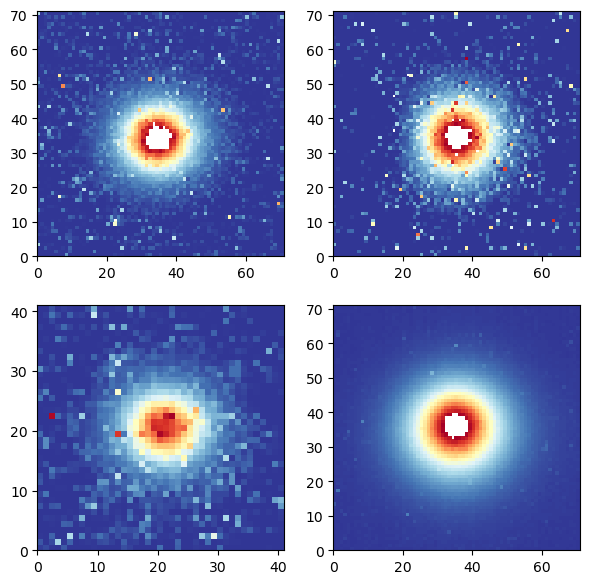

PyObject <matplotlib.collections.QuadMesh object at 0x7f6f0b652100>

In [21]:
fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax[1,1].pcolormesh(event.cam_1, cmap="RdYlBu_r")
ax[1,2].pcolormesh(event.cam_2, cmap="RdYlBu_r")
ax[2,1].pcolormesh(event.cam_3, cmap="RdYlBu_r")
ax[2,2].pcolormesh(event.cam_4, cmap="RdYlBu_r")

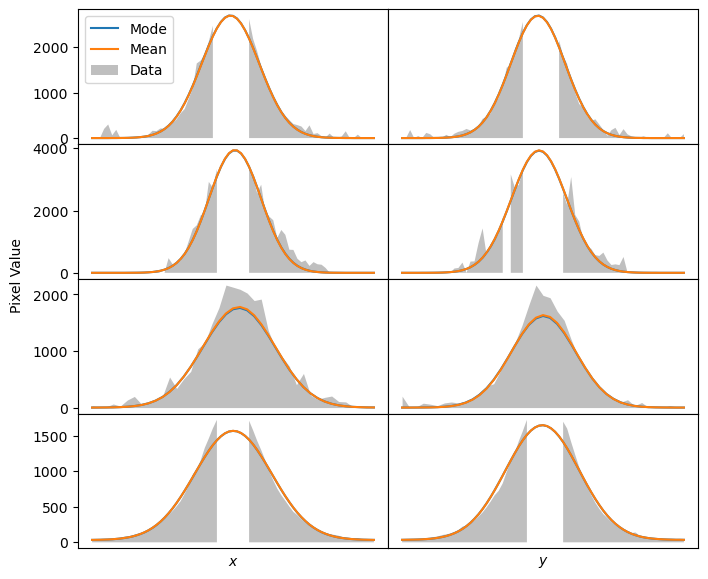

PyObject Text(0.04, 0.5, 'Pixel Value')

In [22]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_crossections(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

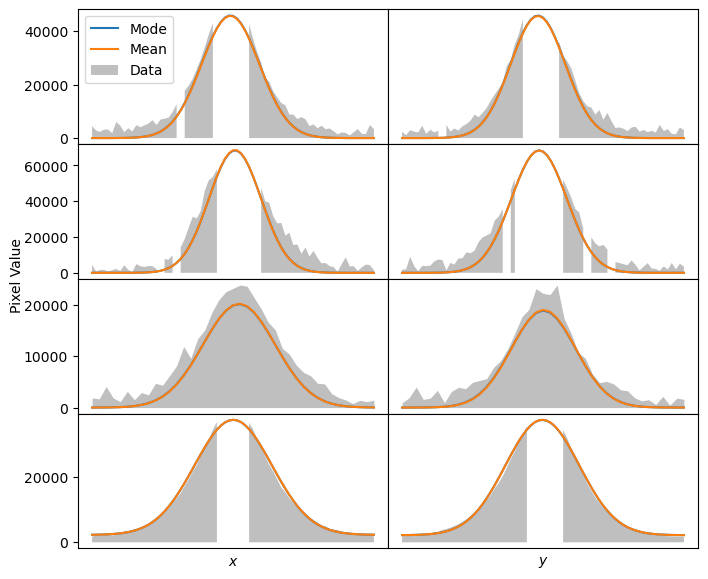

PyObject Text(0.04, 0.5, 'Pixel Value')

In [23]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_integral(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

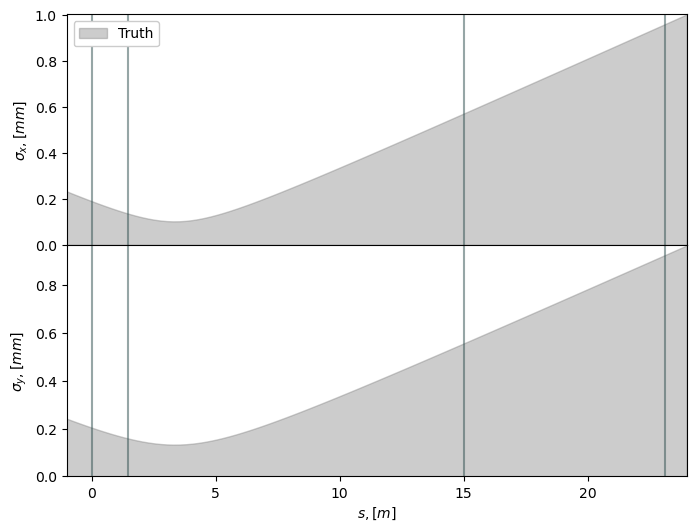

PyObject Text(0.5, 26.28125, '$s, [m]$')

In [24]:
params_array = [mode(samples)[1],]
colors_array = ["gray",]
labels_array = ["Truth", ]

plot_envelop_trajectory(params_array,  labels = labels_array, colors=colors_array)

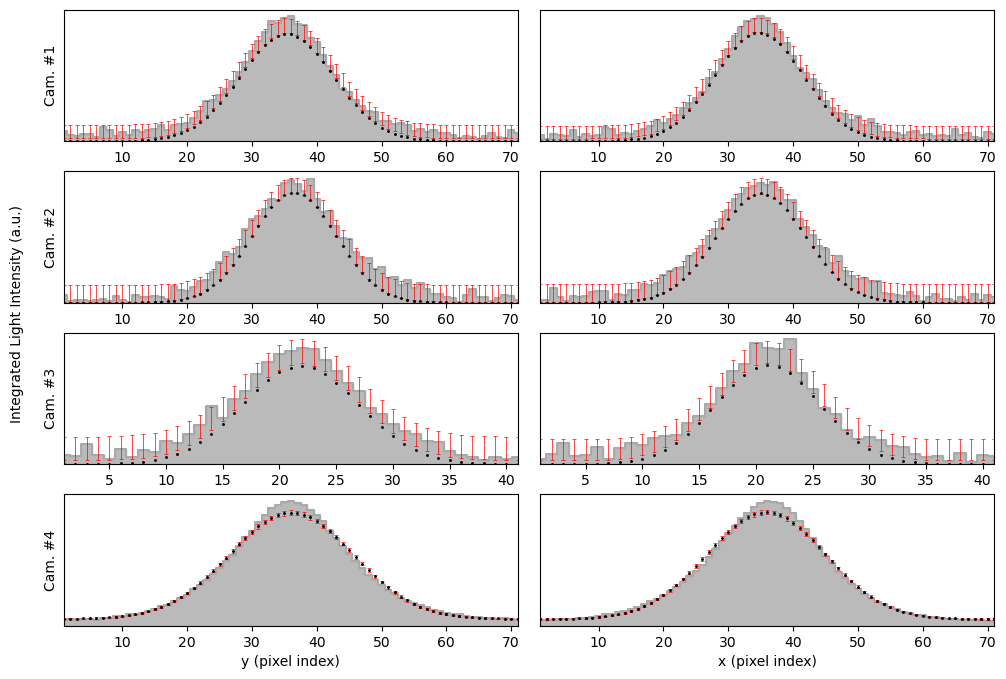

PyObject Text(0.08, 0.5, 'Integrated Light Intensity (a.u.)')

In [25]:
plot_projections(conv_matrices, event_nt, event_nt, params_array[1], isnontr = true)